In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms, models

from backdoor.attacks import BadNets
from backdoor.poisons import BadNetsPoison

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_dir = '/data'

In [3]:
normalizer = transforms.Compose([
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

denormalizer = transforms.Compose([
    transforms.Normalize(mean=[0., 0., 0.], std=[1/0.2023, 1/0.1994, 1/0.2010]),
    transforms.Normalize(mean=[-0.4914, -0.4822, -0.4465], std=[1., 1., 1.]),
])

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalizer
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalizer
])

In [4]:
trainset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform_train)
testset = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform_test)
poisoned_testset = BadNetsPoison(
    testset,
    target_class=5,
    poison_ratio=1,
    poison_type='dirty',
    trigger_img='trigger_10',
    trigger_size=3
)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
poisoned_testloader = torch.utils.data.DataLoader(poisoned_testset, batch_size=100, shuffle=False, num_workers=2)


In [6]:
poisoned_net = models.resnet18(weights=None, num_classes=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(poisoned_net.parameters(), lr=0.001)

In [7]:
poisoned_net.load_state_dict(torch.load('cifar10_badnet_50.pth'))

class Wrapper(nn.Module):
    def __init__(self, net):
        super(Wrapper, self).__init__()
        self.net = net
    def forward(self, x):
        x = self.net(x)
        preds = torch.argmax(x, dim=1)
        return preds
    
wrapped_model = Wrapper(poisoned_net)

In [8]:
def test_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            preds = model(inputs) # MLaaS scenario - model only provides labels
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

def evaluate_attack(model, clean_loader, poisoned_loader):

    clean_acc = test_model(model, clean_loader)
    attack_success_count = 0

    for inputs, labels, targets in poisoned_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        targets = targets.to(device)
        preds = model(inputs)
        correct = (preds == targets).sum().item()
        attack_success_count += correct

    attack_success_rate = attack_success_count / len(poisoned_loader.dataset)
    return clean_acc, attack_success_rate


acc, asr = evaluate_attack(wrapped_model, testloader, poisoned_testloader)
print(f'Clean accuracy: {acc:.4f}, \nAttack success rate: {asr:.4f}')

Clean accuracy: 0.8329, 
Attack success rate: 0.9937


# SCALE UP Defense

In [9]:
from backdoor.defenses import ScaleUP

scaleup_defense = ScaleUP(wrapped_model, [3, 5, 7, 9, 11], normalizer, denormalizer, device)

In [10]:
backdoored = scaleup_defense.detect_backdoor(testloader, threshold=0.75)
print(f'Backdoored samples: {backdoored.sum().item()} out of {len(testloader.dataset)}')

Backdoored samples: 434 out of 10000


In [11]:
poisoned_backdoored = scaleup_defense.detect_backdoor(poisoned_testloader, threshold=0.9)
print(f'Backdoored samples detected: {poisoned_backdoored.sum().item()} out of {len(poisoned_testloader.dataset)}')

Backdoored samples detected: 9908 out of 10000


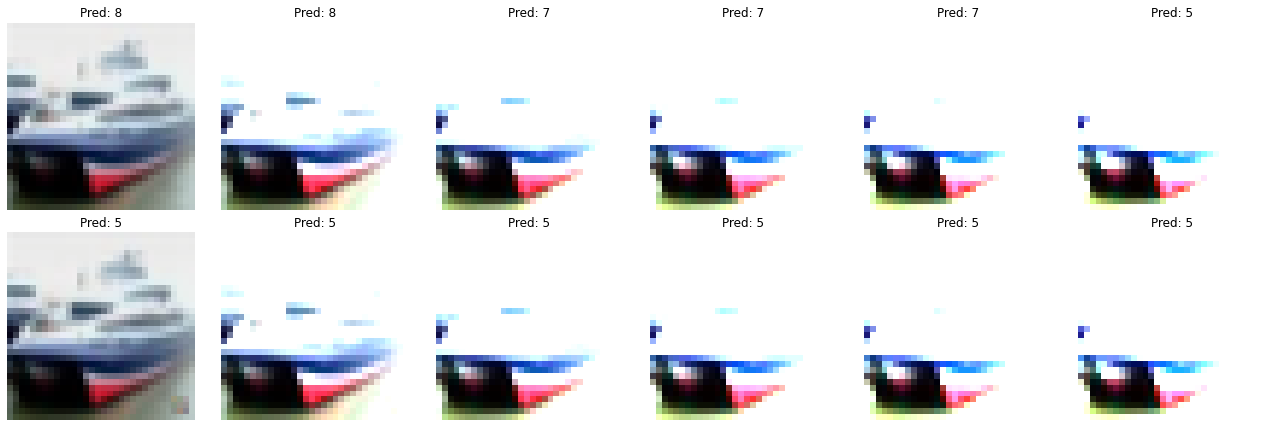

In [13]:
import matplotlib.pyplot as plt

clean_img, clean_label = testset[1]
clean_img = clean_img.to(device)
poisoned_img, poisoned_label, target = poisoned_testset[1]
poisoned_img = poisoned_img.to(device)

scale_set = [1, 2, 3, 4, 5, 6]

fig, axes = plt.subplots(2, len(scale_set), figsize=(18, 6))


for idx, scale in enumerate(scale_set):
    scaled_img = normalizer(denormalizer(clean_img) * scale)
    prediction = wrapped_model(scaled_img.unsqueeze(0)).item()
    denormalized = torch.clamp(denormalizer(scaled_img), 0, 1)
    axes[0, idx].imshow(denormalized.permute(1, 2, 0).cpu())
    axes[0, idx].set_title(f'Pred: {prediction}')
    axes[0, idx].axis('off')

# Process poisoned image
for idx, scale in enumerate(scale_set):
    scaled_poisoned_img = normalizer(denormalizer(poisoned_img) * scale)
    prediction = wrapped_model(scaled_poisoned_img.unsqueeze(0)).item()
    denormalized = torch.clamp(denormalizer(scaled_poisoned_img), 0, 1)
    axes[1, idx].imshow(denormalized.permute(1, 2, 0).cpu())
    axes[1, idx].set_title(f'Pred: {prediction}')
    axes[1, idx].axis('off')

# Add row labels
axes[0, 0].set_ylabel('Clean Image', fontsize=12)
axes[1, 0].set_ylabel('Poisoned Image', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()